## Data Section

In this project we will segment San Diego by its zip code, each zip code is considered as one neighborhood. 
Zip code list is from the zip code directory of Superior Court of California

There are two main database sources will be used in following analysis, FourSquare API and U.S. Census Bureau.

From FourSquare API we get venue location data, grocery store, restaurants, parks, theaters and etc., by correctly grouping venue types into different categories we could find out the level of entertainment and convenience of a given neighborhood. 

U.S. Census Bureau provides us all demographical data, including population density, cost of living, education background, average gross income and etc., all important aspects to know about a neighborhood.


### Import all necessary libraries

In [2]:
import os,sys

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

from bs4 import BeautifulSoup
import requests

# print('Folium installed')
# print('Libraries imported.')

### Get Neighborhood list

The Superior Court of California have a complete list of all zip codes in the county of San Diego. we will use BeautifulSoup to extract this list from their website.

In [3]:
html = 'http://www.sdcourt.ca.gov/portal/page?_pageid=55,1524259&_dad=portal&_schema=PORTAL'
source = requests.get(html).text
soup = BeautifulSoup(source, 'lxml')
ziptable = soup.find('table', attrs={'class':'sdcourttable'})
ziplist = {}
for i in ziptable.find_all('tr'):
    currow = i.find_all('td')
    index = 0
    try:
        while index < 10:
            ziplist[currow[index].get_text().replace('\xa0', '')] = currow[index+1].get_text().replace('\xa0', '')
            index += 3
    except:
        pass


#### Let's look at the list we got.



In [4]:
ziplist

{'91901': 'ALPINE',
 '92037': 'LA JOLLA',
 '92123': 'SD, SERRA MESA',
 '91902': 'BONITA',
 '92038': 'LA JOLLA (POB)',
 '92124': 'SD, TIERRASANTA',
 '91903': 'ALPINE (POB)',
 '92039': 'LA JOLLA (POB)',
 '92126': 'SD, MIRA MESA',
 '91905': 'BOULEVARD',
 '92040': 'LAKESIDE',
 '92127': 'SD, RANCHO BERNARDO',
 '91906': 'CAMPO',
 '92046': 'ESCONDIDO (POB)',
 '92128': 'SD, RANCHO BERNARDO',
 '91908': 'BONITA (POB)',
 '92049': 'OCEANSIDE(POB)',
 '92129': 'SD, RANCHO PENASQUITOS',
 '91909': 'CHULA VISTA (POB)',
 '92051': 'OCEANSIDE(POB)',
 '92130': 'SD, CARMEL VALLEY',
 '91910': 'CHULA VISTA',
 '92052': 'OCEANSIDE(POB)',
 '92131': 'SD, SCRIPPS RANCH',
 '91911': 'CHULA VISTA',
 '92054': 'OCEANSIDE, CAMP PNDLTN',
 '92132': '*SD, (NavalSupply Center)',
 '91912': 'CHULA VISTA (POB)',
 '92055': 'CAMP PENDLETON',
 '92134': '*SD, (Naval Hospital)',
 '91913': 'CHULA VISTA',
 '92056': 'OCEANSIDE',
 '92135': 'SAN DIEGO (POB)',
 '91914': 'CHULA VISTA',
 '92057': 'OCEANSIDE',
 '92136': '*SD (32nd St. Naval


According to Superior Court's instruction, zip codes that start with a asterisk are for a specific company, and those marked as (POB) are PO.Box, since they are not real zip neighborhoods we don't need them in our explore list, remove all these zip codes and store the result in dataframe zip_SD. 

In [5]:
realziplist = []
for key in ziplist:
    if 'POB' not in ziplist[key] and '*' not in ziplist[key]:
        realziplist.append([key, ziplist[key]])
zip_SD = pd.DataFrame(realziplist, columns=['ZipCode', 'Name'])
print('There are %d zip codes (neighborhood) in San Diego.' %zip_SD.shape[0])
zip_SD.head()

There are 99 zip codes (neighborhood) in San Diego.


,ZipCode,Name
0,91901,ALPINE
1,92037,LA JOLLA
2,92123,"SD, SERRA MESA"
3,91902,BONITA
4,92124,"SD, TIERRASANTA"


#### Assign coordinates to each neiborhood to accuire location data later.
We are able to get a text file contains US Zip Codes and their corresponding coordinates from 2018 Government Data using the source below:
http://www.census.gov/geo/maps-data/data/gazetteer.html

Let's read the text file into a pandas dataframe.

In [6]:
zip_national = pd.read_csv('2018_Gaz_zcta_national.txt', sep="\t", converters={'GEOID':str})
zip_national = zip_national.drop(['ALAND','AWATER','ALAND_SQMI','AWATER_SQMI'], axis=1)
zip_national.columns = ['ZipCode', 'Latitude','Longitude']


In [7]:
print(zip_national.shape)
zip_national.head()

(33144, 3)


,ZipCode,Latitude,Longitude
0,00601,18.180555,-66.749961
1,00602,18.361945,-67.175597
2,00603,18.455183,-67.119887
3,00606,18.158327,-66.932928
4,00610,18.295366,-67.125135


#### Add coordinates to previous San Diego zip datafarme by join the two dataframes

In [8]:
zip_coord = zip_SD.merge(zip_national, left_on='ZipCode', right_on='ZipCode', how='inner')
Zip_coord = zip_coord.drop(['ZipCode'], axis=1)
print(zip_coord.shape)
zip_coord.head()

(96, 4)


,ZipCode,Name,Latitude,Longitude
0,91901,ALPINE,32.808563,-116.710076
1,92037,LA JOLLA,32.856347,-117.250058
2,92123,"SD, SERRA MESA",32.806775,-117.134943
3,91902,BONITA,32.665762,-117.018657
4,92124,"SD, TIERRASANTA",32.826521,-117.086015


#### Create a map of San Diego with neighborhoods superimposed on top.

In [9]:
import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [10]:
geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode('San Diego, California')
latitude = location.latitude
longitude = location.longitude
map_SD= folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, zipcode, name in zip(zip_coord['Latitude'], zip_coord['Longitude'], zip_coord['ZipCode'], zip_coord['Name']):
    label = '{}, {}'.format(name, zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_SD)  
    
map_SD

In [11]:
# Github is not able to render the map, here is a screenshot of it
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread('SD Neighborhoods.png')
imgplot = plt.imshow(img)

## Explore Venues in San Diego Neighborhoods

FourSquare API is used here to explore venues and their basic info around each Neighborhood.

First, define FourSquare credentials

In [12]:
CLIENT_ID = 'VTNJI1NBXEBGDETQPO5ITG5ZNRCR0LTLH4BON0L0FMCCQ0YD' # your Foursquare ID
CLIENT_SECRET = 'JCU14KCM31VSSPKWD4H3EFZYB32WD2YBCGCTSM045TANBYII' # your Foursquare Secret
VERSION = '201801122' # Foursquare API version
LIMIT = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VTNJI1NBXEBGDETQPO5ITG5ZNRCR0LTLH4BON0L0FMCCQ0YD
CLIENT_SECRET:JCU14KCM31VSSPKWD4H3EFZYB32WD2YBCGCTSM045TANBYII


#### Create a function to repeat the process of getting venues in each neighborhood.

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
SD_venues = getNearbyVenues(names=zip_coord['ZipCode'],
                                   latitudes=zip_coord['Latitude'],
                                   longitudes=zip_coord['Longitude']
                                  )

In [15]:
print(SD_venues.shape)
SD_venues.head()

(3183, 7)


,ZipCode,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,92037,32.856347,-117.250058,Shorehouse Kitchen,32.853907,-117.254701,Breakfast Spot
1,92037,32.856347,-117.250058,La Jolla Shores Beach,32.857924,-117.256994,Beach
2,92037,32.856347,-117.250058,La Jolla Shores Park,32.858573,-117.255836,Park
3,92037,32.856347,-117.250058,Piatti,32.853954,-117.256167,Italian Restaurant
4,92037,32.856347,-117.250058,Shore Rider,32.854085,-117.256282,Bar


In [16]:
SD_venues.groupby('ZipCode').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
ZipCode,,,,,,
91902,32,32,32,32,32,32
91905,2,2,2,2,2,2
91906,1,1,1,1,1,1
91910,48,48,48,48,48,48
91911,64,64,64,64,64,64
91913,22,22,22,22,22,22
91914,4,4,4,4,4,4
91915,32,32,32,32,32,32
91917,1,1,1,1,1,1


#### Merging venues with zip codes, get a full dataframe of zip codes and their venues, there are some zip codes didn't get any venue information.



In [17]:
zip_venues = zip_coord.merge(SD_venues.drop_duplicates(), on=['ZipCode'], how='left', indicator=True)
zip_venues['_merge'] == 'left_only'
zip_venues.groupby('_merge').count()
# df_all.loc[df_all['_merge']=='left_only']

,ZipCode,Name,Latitude,Longitude,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
_merge,,,,,,,,,,
left_only,10,10,10,10,0,0,0,0,0,0
right_only,0,0,0,0,0,0,0,0,0,0
both,3183,3183,3183,3183,3183,3183,3183,3183,3183,3183


Drop those 11 zip codes with empty venue list, they are most likely in the middle of desert with really low population.


In [18]:
# Drop rows with at least one null value
zip_venues = zip_venues.dropna()

# Drop not needed columns
zip_venues = zip_venues.drop(columns=['_merge', 'Neighborhood Latitude', 'Neighborhood Longitude'])


In [19]:
zip_venues = zip_venues.dropna()
print(zip_venues.shape)
zip_venues.head()

(3183, 8)


,ZipCode,Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,92037,LA JOLLA,32.856347,-117.250058,Shorehouse Kitchen,32.853907,-117.254701,Breakfast Spot
2,92037,LA JOLLA,32.856347,-117.250058,La Jolla Shores Beach,32.857924,-117.256994,Beach
3,92037,LA JOLLA,32.856347,-117.250058,La Jolla Shores Park,32.858573,-117.255836,Park
4,92037,LA JOLLA,32.856347,-117.250058,Piatti,32.853954,-117.256167,Italian Restaurant
5,92037,LA JOLLA,32.856347,-117.250058,Shore Rider,32.854085,-117.256282,Bar


In [20]:
print('There are {} unique categories.'.format(len(zip_venues['Venue Category'].unique())))

There are 307 unique categories.


#### I extracted the category tree from foursquare Venue Categoried page (https://developer.foursquare.com/docs/resources/categories) into a csv file, grouping all venue types into 9 parent categories.

In [21]:
venuecategories = 'Venue Categories.csv'
venuecategoriesDF = pd.read_csv(venuecategories, header=None)
venuecategoriesDF.columns = ['Venue Category', 'Category Parent']
print(venuecategoriesDF.shape)
print(venuecategoriesDF['Category Parent'].unique())
venuecategoriesDF.head()

(1127, 2)
['Food' 'Residence' 'Professional & Other Places' 'Travel & Transport'
 'Arts & Entertainment' 'Outdoors & Recreation' 'Nightlife Spot' 'Event'
 'College & University' nan]


,Venue Category,Category Parent
0,Abruzzo Restaurant,Food
1,Acai House,Food
2,Accessories Store,Residence
3,Acehnese Restaurant,Food
4,Acupuncturist,Professional & Other Places


#### Join the venue categories dataframe with our previous zip_venues

In [22]:
zip_venues_grouped = pd.merge(zip_venues, venuecategoriesDF, on='Venue Category', how='left')
zip_venues_grouped['Category Parent'] = zip_venues_grouped.apply(
    lambda row: row['Venue Category'] if pd.isnull(row['Category Parent']) else row['Category Parent'], axis = 1
)
print(zip_venues_grouped.shape)
zip_venues_grouped.head()

(3183, 9)


,ZipCode,Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category Parent
0,92037,LA JOLLA,32.856347,-117.250058,Shorehouse Kitchen,32.853907,-117.254701,Breakfast Spot,Food
1,92037,LA JOLLA,32.856347,-117.250058,La Jolla Shores Beach,32.857924,-117.256994,Beach,Outdoors & Recreation
2,92037,LA JOLLA,32.856347,-117.250058,La Jolla Shores Park,32.858573,-117.255836,Park,Outdoors & Recreation
3,92037,LA JOLLA,32.856347,-117.250058,Piatti,32.853954,-117.256167,Italian Restaurant,Food
4,92037,LA JOLLA,32.856347,-117.250058,Shore Rider,32.854085,-117.256282,Bar,Nightlife Spot


#### Encoding categorized value 'Catgory Parent'

In [23]:
# one hot encoding
zip_venues_onehot = pd.get_dummies(zip_venues_grouped[['Category Parent']], prefix="", prefix_sep="")
# add ZipCode column back to dataframe
zip_venues_onehot['ZipCode'] = zip_venues_grouped['ZipCode']

# move ZipCode column to the first column
fixed_columns = [zip_venues_onehot.columns[-1]] + list(zip_venues_onehot.columns[:-1])
zip_venues_onehot = zip_venues_onehot[fixed_columns]
print(zip_venues_onehot.shape)
zip_venues_onehot.head()

(3183, 9)


,ZipCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,92037,0,0,1,0,0,0,0,0
1,92037,0,0,0,0,1,0,0,0
2,92037,0,0,0,0,1,0,0,0
3,92037,0,0,1,0,0,0,0,0
4,92037,0,0,0,1,0,0,0,0


#### Next, let's group rows by zip codes and by taking the sum of occurrence of each category

In [24]:
zip_venues_grouped = zip_venues_onehot.groupby('ZipCode').sum().reset_index()
print(zip_venues_grouped.shape)
zip_venues_grouped.head()

(86, 9)


,ZipCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,91902,0,0,16,1,5,0,10,0
1,91905,0,0,0,0,0,0,1,1
2,91906,0,0,0,0,0,1,0,0
3,91910,0,0,23,0,2,0,21,2
4,91911,0,0,35,0,8,0,20,1


## Explore demographics facts in San Diego Neighborhoods

In this section we are going to gathering demographics details of each zip neighborhood as another set of data input for later clustering, where we will including aspects like sex and age, house price, median household income, and etc, shed some light on features such as population, living costs of San Diego's neighborhoods.

Our data is from U.S. Census Bureau / American Community Survey (ACS), an ongoing survey that provides vital information on a yearly basis about United State and its people. The survey covers comprehensive topics, jobs and occupations, educational attainment and business etc.

The database we selected from ACS in this project is the result of survey conducted between 2013-2017.

There are near a thousand tables in the database we are interested, I picked following 12 tables as the demographics features we will be evaluating later. The codes listed at front are table codes in database.

1. B08303 - TRAVEL TIME TO WORK
2. B01003 - TOTAL POPULATION
3. B11004 - FAMILY TYPE BY PRESENCE AND AGE OF RELATED CHILDREN UNDER 18 YEARS
4. B14001 - SCHOOL ENROLLMENT BY LEVEL OF SCHOOL FOR THE POPULATION 3 YEARS AND OVER
5. B19101 - FAMILY INCOME IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS)
6. B25009 - TENURE BY HOUSEHOLD SIZE
7. B25010 - AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE
8. B25064 - MEDIAN GROSS RENT (DOLLARS)
9. B25105 - MEDIAN MONTHLY HOUSING COSTS (DOLLARS)
10. S0101 - AGE AND SEX 
11. S1501 - EDUCATIONAL ATTAINMENT 
12. S2301 - EMPLOYMENT STATUS 


#### Let's look at these tables one by one, and store all tables in one dataframe DemoFactbyZip

In [25]:
DemoFactbyZip = pd.DataFrame()
DemoFactbyZip_noscale = pd.DataFrame()

### 1. TRAVEL TIME TO WORK

The download tables are in csv format, first read it into a pandas dataframe.

In [26]:
TTtoWork = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B08303_with_ann.csv', header=1)
print(TTtoWork.shape)
TTtoWork.head()

(108, 29)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Total: - Less than 5 minutes,Margin of Error; Total: - Less than 5 minutes,Estimate; Total: - 5 to 9 minutes,Margin of Error; Total: - 5 to 9 minutes,Estimate; Total: - 10 to 14 minutes,...,Estimate; Total: - 35 to 39 minutes,Margin of Error; Total: - 35 to 39 minutes,Estimate; Total: - 40 to 44 minutes,Margin of Error; Total: - 40 to 44 minutes,Estimate; Total: - 45 to 59 minutes,Margin of Error; Total: - 45 to 59 minutes,Estimate; Total: - 60 to 89 minutes,Margin of Error; Total: - 60 to 89 minutes,Estimate; Total: - 90 or more minutes,Margin of Error; Total: - 90 or more minutes
0,8600000US91901,91901,ZCTA5 91901,7784,549,127,57,636,194,538,...,456,153,594,186,892,208,828,232,173,80
1,8600000US91902,91902,ZCTA5 91902,8566,755,35,34,125,74,815,...,275,120,528,226,785,226,330,189,237,115
2,8600000US91905,91905,ZCTA5 91905,91,60,15,22,4,5,7,...,0,12,0,12,0,12,34,38,3,6
3,8600000US91906,91906,ZCTA5 91906,1085,277,83,88,173,118,155,...,0,12,0,12,197,86,243,130,92,105
4,8600000US91910,91910,ZCTA5 91910,31995,1148,321,93,2283,277,3517,...,1011,213,1360,312,3117,388,2017,292,630,172


The table counts the number of **workers that 16 years and over who did not work at home. **

Steps to process the table:

a. Rename 'Id2' to "ZipCode"

b. Remove unnecessary columns, "Id", "Geography" and all margin errors

c. Group columns into 4 categories, and calculate their percentage among all families:

**less than 30 minutes, between 30 to 60 minutes, between 60 to 90 minutes, 90 minutes and above**.

In [27]:
# Rename index to "ZipCode"
TTtoWork.rename(columns={'Id2':'ZipCode'},inplace=True)

# Remove "Id", "Geography", and margin error columns
TTtoWork.drop(TTtoWork.columns[[0,2]], axis=1, inplace=True)
errorlist = [i for i in range(1,25) if i % 2 == 0]
TTtoWork.drop(TTtoWork.columns[errorlist], axis=1, inplace=True)

# Combine columns into 4 categories, and calculate percentage
TTtoWork['Commute less than 30 minutes'] = TTtoWork[['Estimate; Total: - Less than 5 minutes','Estimate; Total: - 5 to 9 minutes','Estimate; Total: - 10 to 14 minutes','Estimate; Total: - 15 to 19 minutes','Estimate; Total: - 20 to 24 minutes','Estimate; Total: - 25 to 29 minutes']].sum(axis=1)

TTtoWork['Commute between 30 to 59 minutes'] = TTtoWork[['Estimate; Total: - 30 to 34 minutes','Estimate; Total: - 35 to 39 minutes','Estimate; Total: - 40 to 44 minutes','Estimate; Total: - 45 to 59 minutes']].sum(axis=1)
TTtoWork['Commute between 60 to 89 minutes'] = TTtoWork['Estimate; Total: - 60 to 89 minutes']
TTtoWork['Commute more than 90 minutes'] = TTtoWork['Estimate; Total: - 90 or more minutes']

TTtoWork['PERCENT Commute less than 30 minutes'] = TTtoWork['Commute less than 30 minutes'].astype('float') / TTtoWork['Estimate; Total:'].astype(float)
TTtoWork['PERCENT Commute between 30 to 59 minutes'] = TTtoWork['Commute between 30 to 59 minutes'].astype('float') / TTtoWork['Estimate; Total:'].astype(float)
TTtoWork['PERCENT Commute between 60 to 89 minutes'] = TTtoWork['Commute between 60 to 89 minutes'].astype('float') / TTtoWork['Estimate; Total:'].astype(float)
TTtoWork['PERCENT Commute more than 90 minutes'] = TTtoWork['Commute more than 90 minutes'].astype('float') / TTtoWork['Estimate; Total:'].astype(float)

TTtoWork.drop(TTtoWork.columns[range(1,TTtoWork.shape[1]-4)], axis=1, inplace=True)
TTtoWork.head()


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes
0,91901,0.469938,0.401465,0.106372,0.022225
1,91902,0.581602,0.352206,0.038524,0.027668
2,91905,0.395604,0.197802,0.373626,0.032967
3,91906,0.465438,0.225806,0.223963,0.084793
4,91910,0.587967,0.329301,0.063041,0.019691


#### Store this table into our final dataframe

In [28]:
DemoFactbyZip = TTtoWork
DemoFactbyZip_noscale = TTtoWork


### 2. TOTAL POPULATION

Load data into frame Population

In [29]:
Population = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B01003_with_ann.csv', header=1)
print(Population.shape)
Population.head()

(108, 5)


,Id,Id2,Geography,Estimate; Total,Margin of Error; Total
0,8600000US91901,91901,ZCTA5 91901,18238,997
1,8600000US91902,91902,ZCTA5 91902,19762,1376
2,8600000US91905,91905,ZCTA5 91905,1528,486
3,8600000US91906,91906,ZCTA5 91906,3426,564
4,8600000US91910,91910,ZCTA5 91910,76250,1826


Remove unnecessary columns, and rename 'Id2' to "ZipCode", to make the process easier, create a function "preprocess"

In [30]:
def preprocess(df):
    df.rename(columns={'Id2':'ZipCode'},inplace=True)
    df.drop(df.columns[[0,2]],axis=1,inplace=True)
    marginerrors = [i for i in range(1,df.shape[1]) if i % 2 == 0]
    df.drop(df.columns[marginerrors],axis=1,inplace=True)
    return df
print("preprocess created!! This function renames dataframe index to 'ZipCode', remove 'Id' and 'Geography', and remove all margin errors")

preprocess created!! This function renames dataframe index to 'ZipCode', remove 'Id' and 'Geography', and remove all margin errors


In [31]:
# Preprocess Populations
preprocess(Population)

# Rename population column to "Total Population"                                 
Population.rename(columns={'Estimate; Total':'Total Population'},inplace=True)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, Population, how='outer', on='ZipCode', sort=False)
Population.head()

,ZipCode,Total Population
0,91901,18238
1,91902,19762
2,91905,1528
3,91906,3426
4,91910,76250


#### It is obvious these numbers are orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected, we need to scale this column to range of 0 to 1 using sklearn preprocessing module, where the minimum number to be 1, maximum number to be 0, and all other to be spread accordingly. 


In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Population[['Total Population']] = scaler.fit_transform(Population[['Total Population']])
Population.head()


,ZipCode,Total Population
0,91901,0.209108
1,91902,0.226582
2,91905,0.017519
3,91906,0.039281
4,91910,0.874246


#### Now Combine scaled dataset into the final dataframe


In [33]:
DemoFactbyZip = pd.merge(DemoFactbyZip, Population, how='outer', on='ZipCode', sort=False,)
DemoFactbyZip.head()

,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246


### 3. FAMILY TYPE BY PRESENCE AND AGE OF RELATED CHILDREN UNDER 18 YEARS

Load data into frame FamilywChildren

In [34]:
FamilywChildren = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B11004_with_ann.csv', header=1)
print(FamilywChildren.shape)
FamilywChildren.head()

(108, 43)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Married-couple family:,Margin of Error; Married-couple family:,Estimate; Married-couple family: - With related children of the householder under 18 years:,Margin of Error; Married-couple family: - With related children of the householder under 18 years:,Estimate; Married-couple family: - With related children of the householder under 18 years: - Under 6 years only,...,"Estimate; Other family: - Female householder, no husband present: - With related children of the householder under 18 years:","Margin of Error; Other family: - Female householder, no husband present: - With related children of the householder under 18 years:","Estimate; Other family: - Female householder, no husband present: - With related children of the householder under 18 years: - Under 6 years only","Margin of Error; Other family: - Female householder, no husband present: - With related children of the householder under 18 years: - Under 6 years only","Estimate; Other family: - Female householder, no husband present: - With related children of the householder under 18 years: - Under 6 years and 6 to 17 years","Margin of Error; Other family: - Female householder, no husband present: - With related children of the householder under 18 years: - Under 6 years and 6 to 17 years","Estimate; Other family: - Female householder, no husband present: - With related children of the householder under 18 years: - 6 to 17 years only","Margin of Error; Other family: - Female householder, no husband present: - With related children of the householder under 18 years: - 6 to 17 years only","Estimate; Other family: - Female householder, no husband present: - No related children of the householder under 18 years","Margin of Error; Other family: - Female householder, no husband present: - No related children of the householder under 18 years"
0,8600000US91901,91901,ZCTA5 91901,4697,287,3793,292,1446,241,344,...,453,192,142,118,1,2,310,133,205,101
1,8600000US91902,91902,ZCTA5 91902,4695,309,3998,329,1653,211,356,...,286,123,16,19,8,13,262,121,196,76
2,8600000US91905,91905,ZCTA5 91905,416,181,311,164,52,39,0,...,8,11,3,6,0,12,5,7,74,93
3,8600000US91906,91906,ZCTA5 91906,753,161,443,131,182,106,108,...,106,63,44,47,40,50,22,23,52,46
4,8600000US91910,91910,ZCTA5 91910,17999,478,12037,552,5653,428,1006,...,2238,299,380,122,508,151,1350,258,1714,223


To process this table, first preprocess the table as above, calculate the percentage of families with children under 18 years old for the following three family types:

*PERCENT Married-couple family with related children of the householder under 18 years*  
*PERCENT Male householder, no wife present with related children of the householder under 18 years*  
*PERCENT Female householder, no husband present with related children of the householder under 18 years*


In [35]:
# Preprocess FamilywChildren
preprocess(FamilywChildren)

# Calculate the percentage of three family types, and remove all other columns
FamilywChildren['PERCENT Married-couple family with related children of the householder under 18 years'] = FamilywChildren['Estimate; Married-couple family: - With related children of the householder under 18 years:'].astype(float)/FamilywChildren['Estimate; Married-couple family:'].astype(float)
FamilywChildren['PERCENT Male householder, no wife present with related children of the householder under 18 years'] = FamilywChildren['Estimate; Other family: - Male householder, no wife present: - With related children of the householder under 18 years:'].astype(float)/FamilywChildren['Estimate; Other family: - Male householder, no wife present:'].astype(float)
FamilywChildren['PERCENT Female householder, no husband present with related children of the householder under 18 years'] = FamilywChildren['Estimate; Other family: - Female householder, no husband present: - With related children of the householder under 18 years:'].astype(float)/FamilywChildren['Estimate; Other family: - Female householder, no husband present:'].astype(float)
FamilywChildren.drop(FamilywChildren.columns[range(1, FamilywChildren.shape[1]-3)],axis=1,inplace=True)

print(FamilywChildren.shape)
FamilywChildren.head()


(108, 4)


,ZipCode,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years"
0,91901,0.381229,0.752033,0.688450
1,91902,0.413457,0.567442,0.593361
2,91905,0.167203,0.913043,0.097561
3,91906,0.410835,0.717105,0.670886
4,91910,0.469635,0.446766,0.566296


In [36]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, FamilywChildren, how='outer', on='ZipCode', sort=False)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, FamilywChildren, how='outer', on='ZipCode', sort=False,)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 9)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years"
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296


### 4. SCHOOL ENROLLMENT BY LEVEL OF SCHOOL FOR THE POPULATION 3 YEARS AND OVER

Load data into frame SchoolEnroll

In [37]:
SchoolEnroll = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B14001_with_ann.csv', header=1)
print(SchoolEnroll.shape)
SchoolEnroll.head()


(108, 23)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Enrolled in school:,Margin of Error; Enrolled in school:,"Estimate; Enrolled in school: - Enrolled in nursery school, preschool","Margin of Error; Enrolled in school: - Enrolled in nursery school, preschool",Estimate; Enrolled in school: - Enrolled in kindergarten,...,Estimate; Enrolled in school: - Enrolled in grade 5 to grade 8,Margin of Error; Enrolled in school: - Enrolled in grade 5 to grade 8,Estimate; Enrolled in school: - Enrolled in grade 9 to grade 12,Margin of Error; Enrolled in school: - Enrolled in grade 9 to grade 12,"Estimate; Enrolled in school: - Enrolled in college, undergraduate years","Margin of Error; Enrolled in school: - Enrolled in college, undergraduate years",Estimate; Enrolled in school: - Graduate or professional school,Margin of Error; Enrolled in school: - Graduate or professional school,Estimate; Not enrolled in school,Margin of Error; Not enrolled in school
0,8600000US91901,91901,ZCTA5 91901,17334,910,4851,517,191,80,180,...,847,196,1519,311,1372,334,217,87,12483,625
1,8600000US91902,91902,ZCTA5 91902,19172,1358,5038,616,109,68,174,...,1069,285,909,230,1473,346,306,121,14134,959
2,8600000US91905,91905,ZCTA5 91905,1518,486,188,117,0,12,1,...,55,41,90,63,12,26,0,12,1330,466
3,8600000US91906,91906,ZCTA5 91906,3111,503,824,290,4,5,34,...,58,55,237,137,289,205,37,37,2287,388
4,8600000US91910,91910,ZCTA5 91910,73546,1710,19672,981,733,186,1121,...,3646,355,4523,505,5190,475,818,207,53874,1397


**The total estimate is population 3 years and over.  
Alter the table, combine columns into following 4 categories, and calculate the percentage of each category among total students enrolled in school**  

*Enrolled in preschool and kindergarten  
Enrolled in grade 1 to 12  
Enrolled in undergraduate school  
Enrolled in Graduate school*

In [38]:
# Preprocess the dataframe
preprocess(SchoolEnroll)

# Combine columns into 5 categories，calculate the percentage
SchoolEnroll['PERCENT Enrolled in preschool and kindergarten'] = (SchoolEnroll['Estimate; Enrolled in school: - Enrolled in nursery school, preschool'].astype(float) + SchoolEnroll['Estimate; Enrolled in school: - Enrolled in kindergarten'].astype(float)) / SchoolEnroll['Estimate; Enrolled in school:'].astype(float)
SchoolEnroll['PERCENT Enrolled in grade 1 to 12'] = (SchoolEnroll['Estimate; Enrolled in school: - Enrolled in grade 1 to grade 4'].astype(float) + SchoolEnroll['Estimate; Enrolled in school: - Enrolled in grade 5 to grade 8'].astype(float) + SchoolEnroll['Estimate; Enrolled in school: - Enrolled in grade 9 to grade 12'].astype(float)) / SchoolEnroll['Estimate; Enrolled in school:'].astype(float)
SchoolEnroll['PERCENT Enrolled in undergraduate school'] = SchoolEnroll['Estimate; Enrolled in school: - Enrolled in college, undergraduate years'].astype(float) / SchoolEnroll['Estimate; Enrolled in school:'].astype(float)
SchoolEnroll['PERCENT Enrolled in graduate school'] = SchoolEnroll['Estimate; Enrolled in school: - Graduate or professional school'].astype(float) / SchoolEnroll['Estimate; Enrolled in school:'].astype(float)

# Remove other columns
SchoolEnroll.drop(SchoolEnroll.columns[range(1,SchoolEnroll.shape[1]-4)],axis=1,inplace=True)

print(SchoolEnroll.shape)
SchoolEnroll.head()


(108, 5)


,ZipCode,PERCENT Enrolled in preschool and kindergarten,PERCENT Enrolled in grade 1 to 12,PERCENT Enrolled in undergraduate school,PERCENT Enrolled in graduate school
0,91901,0.076479,0.595960,0.282828,0.044733
1,91902,0.056173,0.590711,0.292378,0.060738
2,91905,0.005319,0.930851,0.063830,0.000000
3,91906,0.046117,0.558252,0.350728,0.044903
4,91910,0.094246,0.600346,0.263827,0.041582


In [39]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, SchoolEnroll, how='outer', on='ZipCode', sort=False)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, SchoolEnroll, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 13)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,PERCENT Enrolled in grade 1 to 12,PERCENT Enrolled in undergraduate school,PERCENT Enrolled in graduate school
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,0.595960,0.282828,0.044733
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,0.590711,0.292378,0.060738
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,0.930851,0.063830,0.000000
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,0.558252,0.350728,0.044903
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,0.600346,0.263827,0.041582


### 5. FAMILY INCOME IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS)

Load data into frame FamilyIncome

In [40]:
FamilyIncome = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B19101_with_ann.csv', header=1)
print(FamilyIncome.shape)
FamilyIncome.head()


(108, 37)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,"Estimate; Total: - Less than $10,000","Margin of Error; Total: - Less than $10,000","Estimate; Total: - $10,000 to $14,999","Margin of Error; Total: - $10,000 to $14,999","Estimate; Total: - $15,000 to $19,999",...,"Estimate; Total: - $75,000 to $99,999","Margin of Error; Total: - $75,000 to $99,999","Estimate; Total: - $100,000 to $124,999","Margin of Error; Total: - $100,000 to $124,999","Estimate; Total: - $125,000 to $149,999","Margin of Error; Total: - $125,000 to $149,999","Estimate; Total: - $150,000 to $199,999","Margin of Error; Total: - $150,000 to $199,999","Estimate; Total: - $200,000 or more","Margin of Error; Total: - $200,000 or more"
0,8600000US91901,91901,ZCTA5 91901,4697,287,198,119,17,18,99,...,571,155,673,178,659,166,667,164,447,119
1,8600000US91902,91902,ZCTA5 91902,4695,309,59,51,23,20,31,...,778,179,692,195,500,146,749,207,544,130
2,8600000US91905,91905,ZCTA5 91905,416,181,85,86,19,27,1,...,48,42,74,91,0,12,14,22,0,12
3,8600000US91906,91906,ZCTA5 91906,753,161,81,63,3,5,50,...,69,45,106,60,47,41,60,58,2,3
4,8600000US91910,91910,ZCTA5 91910,17999,478,807,194,604,180,751,...,2804,303,2157,269,1244,230,1365,229,856,171


**Alter the table, calculate the percentage of following 5 categories:  **

*Income less than 10,000  
Income between 10,000 to 50,000  
Income between 50,000 to 100,000  
Income between 100,000 to 200,000  
Income 200,000 and above  
*

In [41]:
# Preprocess dataframe
preprocess(FamilyIncome)

# Combine columns and calculate percentage
FamilyIncome['PERCENT Family Income less than 10,000'] = FamilyIncome['Estimate; Total: - Less than $10,000'].astype(float) / FamilyIncome['Estimate; Total:'].astype(float)
FamilyIncome['PERCENT Family Income between 10,000 to 50,000'] = (FamilyIncome['Estimate; Total: - $10,000 to $14,999'].astype(float) + FamilyIncome['Estimate; Total: - $15,000 to $19,999'].astype(float) + FamilyIncome['Estimate; Total: - $20,000 to $24,999'].astype(float) + FamilyIncome['Estimate; Total: - $25,000 to $29,999'].astype(float) + FamilyIncome['Estimate; Total: - $30,000 to $34,999'].astype(float) + FamilyIncome['Estimate; Total: - $40,000 to $44,999'].astype(float) + FamilyIncome['Estimate; Total: - $45,000 to $49,999'].astype(float)) / FamilyIncome['Estimate; Total:'].astype(float)
FamilyIncome['PERCENT Family Income between 50,000 to 100,000'] = (FamilyIncome['Estimate; Total: - $50,000 to $59,999'].astype(float) + FamilyIncome['Estimate; Total: - $60,000 to $74,999'].astype(float) + FamilyIncome['Estimate; Total: - $75,000 to $99,999'].astype(float)) / FamilyIncome['Estimate; Total:'].astype(float)
FamilyIncome['PERCENT Family Income between 100,000 to 200,000'] = (FamilyIncome['Estimate; Total: - $100,000 to $124,999'].astype(float) + FamilyIncome['Estimate; Total: - $125,000 to $149,999'].astype(float) + FamilyIncome['Estimate; Total: - $150,000 to $199,999'].astype(float)) / FamilyIncome['Estimate; Total:'].astype(float)
FamilyIncome['PERCENT Family Income 200,000 or more'] = FamilyIncome['Estimate; Total: - $200,000 or more'].astype(float) / FamilyIncome['Estimate; Total:'].astype(float)

FamilyIncome.drop(FamilyIncome.columns[range(1,FamilyIncome.shape[1]-5)],axis=1,inplace=True)

print(FamilyIncome.shape)
FamilyIncome.head()


(108, 6)


,ZipCode,"PERCENT Family Income less than 10,000","PERCENT Family Income between 10,000 to 50,000","PERCENT Family Income between 50,000 to 100,000","PERCENT Family Income between 100,000 to 200,000","PERCENT Family Income 200,000 or more"
0,91901,0.042155,0.148605,0.259953,0.425591,0.095167
1,91902,0.012567,0.133546,0.317998,0.413419,0.115868
2,91905,0.204327,0.319712,0.257212,0.211538,0.000000
3,91906,0.107570,0.241700,0.328021,0.282869,0.002656
4,91910,0.044836,0.281405,0.320907,0.264792,0.047558


In [42]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, FamilyIncome, how='outer', on='ZipCode', sort=False)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, FamilyIncome, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 18)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,PERCENT Enrolled in grade 1 to 12,PERCENT Enrolled in undergraduate school,PERCENT Enrolled in graduate school,"PERCENT Family Income less than 10,000","PERCENT Family Income between 10,000 to 50,000","PERCENT Family Income between 50,000 to 100,000","PERCENT Family Income between 100,000 to 200,000","PERCENT Family Income 200,000 or more"
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,0.595960,0.282828,0.044733,0.042155,0.148605,0.259953,0.425591,0.095167
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,0.590711,0.292378,0.060738,0.012567,0.133546,0.317998,0.413419,0.115868
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,0.930851,0.063830,0.000000,0.204327,0.319712,0.257212,0.211538,0.000000
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,0.558252,0.350728,0.044903,0.107570,0.241700,0.328021,0.282869,0.002656
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,0.600346,0.263827,0.041582,0.044836,0.281405,0.320907,0.264792,0.047558


### 6. TENURE BY HOUSEHOLD SIZE

Load data into frame TenureHouseholdSize

In [43]:
TenureHouseholdSize = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B25009_with_ann.csv', header=1)
print(TenureHouseholdSize.shape)
TenureHouseholdSize.head()


(108, 37)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Owner occupied:,Margin of Error; Owner occupied:,Estimate; Owner occupied: - 1-person household,Margin of Error; Owner occupied: - 1-person household,Estimate; Owner occupied: - 2-person household,...,Estimate; Renter occupied: - 3-person household,Margin of Error; Renter occupied: - 3-person household,Estimate; Renter occupied: - 4-person household,Margin of Error; Renter occupied: - 4-person household,Estimate; Renter occupied: - 5-person household,Margin of Error; Renter occupied: - 5-person household,Estimate; Renter occupied: - 6-person household,Margin of Error; Renter occupied: - 6-person household,Estimate; Renter occupied: - 7-or-more person household,Margin of Error; Renter occupied: - 7-or-more person household
0,8600000US91901,91901,ZCTA5 91901,6420,204,4778,232,936,217,1761,...,278,106,331,140,55,62,0,19,24,37
1,8600000US91902,91902,ZCTA5 91902,6078,272,4415,317,776,165,1627,...,403,146,223,120,60,48,123,76,111,81
2,8600000US91905,91905,ZCTA5 91905,610,220,369,159,71,50,152,...,0,12,5,10,15,22,0,12,0,12
3,8600000US91906,91906,ZCTA5 91906,1094,198,754,193,140,80,365,...,84,84,22,22,2,4,6,7,33,50
4,8600000US91910,91910,ZCTA5 91910,25375,454,12013,472,2540,271,4126,...,2309,305,2076,292,1203,228,542,169,157,81


**Alter tables, calculate the percentage of following categories**  

*Owner occupied  
Owner occupied - 1 to 4 person household  
Owner occupied - 5 or more person household  
Renter occupied  
Renter occupied - 1 to 4 person household  
Renter occupied - 5 or more person household  
*


In [44]:
# Preprocess dataframe
preprocess(TenureHouseholdSize)

# Alter table into above categories and calculate the percentage
TenureHouseholdSize['PERCENT Owner Occupied'] = TenureHouseholdSize['Estimate; Owner occupied:'].astype(float) / TenureHouseholdSize['Estimate; Total:'].astype(float)
TenureHouseholdSize['PERCENT Owner Occupied - 1 to 4 person'] = (TenureHouseholdSize['Estimate; Owner occupied: - 1-person household'].astype(float) + TenureHouseholdSize['Estimate; Owner occupied: - 2-person household'].astype(float) + TenureHouseholdSize['Estimate; Owner occupied: - 3-person household'].astype(float) + TenureHouseholdSize['Estimate; Owner occupied: - 4-person household'].astype(float)) / TenureHouseholdSize['Estimate; Owner occupied:'].astype(float)
TenureHouseholdSize['PERCENT Owner Occupied - 5 or more person'] = (TenureHouseholdSize['Estimate; Owner occupied: - 5-person household'].astype(float) + TenureHouseholdSize['Estimate; Owner occupied: - 6-person household'].astype(float) + TenureHouseholdSize['Estimate; Owner occupied: - 7-or-more person household'].astype(float)) / TenureHouseholdSize['Estimate; Owner occupied:'].astype(float)

TenureHouseholdSize['PERCENT Renter Occupied'] = TenureHouseholdSize['Estimate; Renter occupied:'].astype(float) / TenureHouseholdSize['Estimate; Total:'].astype(float)
TenureHouseholdSize['PERCENT Renter Occupied - 1 to 4 person'] = (TenureHouseholdSize['Estimate; Renter occupied: - 1-person household'].astype(float) + TenureHouseholdSize['Estimate; Renter occupied: - 2-person household'].astype(float) + TenureHouseholdSize['Estimate; Renter occupied: - 3-person household'].astype(float) + TenureHouseholdSize['Estimate; Renter occupied: - 4-person household'].astype(float)) / TenureHouseholdSize['Estimate; Renter occupied:'].astype(float)
TenureHouseholdSize['PERCENT Renter Occupied - 5 or more person'] = (TenureHouseholdSize['Estimate; Renter occupied: - 5-person household'].astype(float) + TenureHouseholdSize['Estimate; Renter occupied: - 6-person household'].astype(float) + TenureHouseholdSize['Estimate; Renter occupied: - 7-or-more person household'].astype(float)) / TenureHouseholdSize['Estimate; Renter occupied:'].astype(float)

TenureHouseholdSize.drop(TenureHouseholdSize.columns[range(1,TenureHouseholdSize.shape[1]-6)],axis=1,inplace=True)

print(TenureHouseholdSize.shape)
TenureHouseholdSize.head()


(108, 7)


,ZipCode,PERCENT Owner Occupied,PERCENT Owner Occupied - 1 to 4 person,PERCENT Owner Occupied - 5 or more person,PERCENT Renter Occupied,PERCENT Renter Occupied - 1 to 4 person,PERCENT Renter Occupied - 5 or more person
0,91901,0.744237,0.879866,0.120134,0.255763,0.951888,0.048112
1,91902,0.726390,0.849604,0.150396,0.273610,0.823211,0.176789
2,91905,0.604918,0.937669,0.062331,0.395082,0.937759,0.062241
3,91906,0.689214,0.810345,0.189655,0.310786,0.879412,0.120588
4,91910,0.473419,0.868143,0.131857,0.526581,0.857656,0.142344


In [45]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, TenureHouseholdSize, how='outer', on='ZipCode', sort=False)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, TenureHouseholdSize, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 24)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,"PERCENT Family Income between 10,000 to 50,000","PERCENT Family Income between 50,000 to 100,000","PERCENT Family Income between 100,000 to 200,000","PERCENT Family Income 200,000 or more",PERCENT Owner Occupied,PERCENT Owner Occupied - 1 to 4 person,PERCENT Owner Occupied - 5 or more person,PERCENT Renter Occupied,PERCENT Renter Occupied - 1 to 4 person,PERCENT Renter Occupied - 5 or more person
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.148605,0.259953,0.425591,0.095167,0.744237,0.879866,0.120134,0.255763,0.951888,0.048112
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.133546,0.317998,0.413419,0.115868,0.726390,0.849604,0.150396,0.273610,0.823211,0.176789
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.319712,0.257212,0.211538,0.000000,0.604918,0.937669,0.062331,0.395082,0.937759,0.062241
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.241700,0.328021,0.282869,0.002656,0.689214,0.810345,0.189655,0.310786,0.879412,0.120588
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.281405,0.320907,0.264792,0.047558,0.473419,0.868143,0.131857,0.526581,0.857656,0.142344


### 7. AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE

Load data into frame AvgHouseSizebyHousingType

In [46]:
AvgHouseSizebyHousingType = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B25010_with_ann.csv', header=1)
print(AvgHouseSizebyHousingType.shape)
AvgHouseSizebyHousingType.head()


(108, 9)


,Id,Id2,Geography,Estimate; Total:,Margin of Error; Total:,Estimate; Total: - Owner occupied,Margin of Error; Total: - Owner occupied,Estimate; Total: - Renter occupied,Margin of Error; Total: - Renter occupied
0,8600000US91901,91901,ZCTA5 91901,2.77,0.13,2.86,0.16,2.54,0.31
1,8600000US91902,91902,ZCTA5 91902,3.24,0.17,3.17,0.23,3.43,0.38
2,8600000US91905,91905,ZCTA5 91905,2.31,0.38,2.64,0.46,1.79,0.66
3,8600000US91906,91906,ZCTA5 91906,2.99,0.47,3.02,0.58,2.92,0.96
4,8600000US91910,91910,ZCTA5 91910,2.96,0.06,3.00,0.09,2.93,0.09


**Rename column names as following**   

*Average Household Size  
Average Owner Occupied Household Size  
Average Renter Occupied Household Size
*

In [47]:
# Preprocess the dataframe
preprocess(AvgHouseSizebyHousingType)

# Rename columns
AvgHouseSizebyHousingType.columns = ['ZipCode', 'Average Household Size', 'Average Owner Occupied Household Size', 'Average Renter Occupied Household Size']

print(AvgHouseSizebyHousingType.shape)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, AvgHouseSizebyHousingType, how='outer', on='ZipCode', sort=False,)
AvgHouseSizebyHousingType.head()


(108, 4)


,ZipCode,Average Household Size,Average Owner Occupied Household Size,Average Renter Occupied Household Size
0,91901,2.77,2.86,2.54
1,91902,3.24,3.17,3.43
2,91905,2.31,2.64,1.79
3,91906,2.99,3.02,2.92
4,91910,2.96,3.00,2.93


#### Scale the numbers to range 0 to 1 using sklearn preprocessing, if there are values that are not recognizable, replace them with 0 as these area possibly don't have enough population for these type of data


In [48]:
AvgHouseSizebyHousingType.replace('-', 0, inplace=True)
scaler = MinMaxScaler()
AvgHouseSizebyHousingType[['Average Household Size', 'Average Owner Occupied Household Size', 'Average Renter Occupied Household Size']] = scaler.fit_transform(AvgHouseSizebyHousingType[['Average Household Size', 'Average Owner Occupied Household Size', 'Average Renter Occupied Household Size']])
AvgHouseSizebyHousingType.head()


,ZipCode,Average Household Size,Average Owner Occupied Household Size,Average Renter Occupied Household Size
0,91901,0.368842,0.333722,0.510040
1,91902,0.431425,0.369895,0.688755
2,91905,0.307590,0.308051,0.359438
3,91906,0.398136,0.352392,0.586345
4,91910,0.394141,0.350058,0.588353


In [49]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, AvgHouseSizebyHousingType, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 27)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,"PERCENT Family Income 200,000 or more",PERCENT Owner Occupied,PERCENT Owner Occupied - 1 to 4 person,PERCENT Owner Occupied - 5 or more person,PERCENT Renter Occupied,PERCENT Renter Occupied - 1 to 4 person,PERCENT Renter Occupied - 5 or more person,Average Household Size,Average Owner Occupied Household Size,Average Renter Occupied Household Size
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.095167,0.744237,0.879866,0.120134,0.255763,0.951888,0.048112,0.368842,0.333722,0.510040
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.115868,0.726390,0.849604,0.150396,0.273610,0.823211,0.176789,0.431425,0.369895,0.688755
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.000000,0.604918,0.937669,0.062331,0.395082,0.937759,0.062241,0.307590,0.308051,0.359438
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.002656,0.689214,0.810345,0.189655,0.310786,0.879412,0.120588,0.398136,0.352392,0.586345
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.047558,0.473419,0.868143,0.131857,0.526581,0.857656,0.142344,0.394141,0.350058,0.588353


### 8. MEDIAN GROSS RENT (DOLLARS)

Load data into frame MedianRent

In [50]:
MedianRent = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B25064_with_ann.csv', header=1)
print(MedianRent.shape)
MedianRent.head()


(108, 5)


,Id,Id2,Geography,Estimate; Median gross rent,Margin of Error; Median gross rent
0,8600000US91901,91901,ZCTA5 91901,1397,73
1,8600000US91902,91902,ZCTA5 91902,1777,92
2,8600000US91905,91905,ZCTA5 91905,706,145
3,8600000US91906,91906,ZCTA5 91906,968,205
4,8600000US91910,91910,ZCTA5 91910,1298,37


**Rename column names as following**  

*Median Gross Rent*

In [51]:
# Preprocess the dataframe
preprocess(MedianRent)

# Rename column
MedianRent.columns=['ZipCode','Median Gross Rent']
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, MedianRent, how='outer', on='ZipCode', sort=False)
MedianRent.head()


,ZipCode,Median Gross Rent
0,91901,1397
1,91902,1777
2,91905,706
3,91906,968
4,91910,1298


#### Scale the numbers to range of 0 to 1, fill '-' value with zero
#### When doing the scaling, it shows the original data contain a value '4,000+' that can't be auto convert to float type, it could be how the data intial entered, we need manually convert it to 4000

In [52]:
MedianRent.replace('-', 0, inplace=True)
scaler = MinMaxScaler()
MedianRent[['Median Gross Rent']] = scaler.fit_transform(MedianRent[['Median Gross Rent']])
MedianRent.head()



,ZipCode,Median Gross Rent
0,91901,0.550433
1,91902,0.700158
2,91905,0.278172
3,91906,0.381403
4,91910,0.511426


In [53]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, MedianRent, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 28)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,PERCENT Owner Occupied,PERCENT Owner Occupied - 1 to 4 person,PERCENT Owner Occupied - 5 or more person,PERCENT Renter Occupied,PERCENT Renter Occupied - 1 to 4 person,PERCENT Renter Occupied - 5 or more person,Average Household Size,Average Owner Occupied Household Size,Average Renter Occupied Household Size,Median Gross Rent
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.744237,0.879866,0.120134,0.255763,0.951888,0.048112,0.368842,0.333722,0.510040,0.550433
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.726390,0.849604,0.150396,0.273610,0.823211,0.176789,0.431425,0.369895,0.688755,0.700158
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.604918,0.937669,0.062331,0.395082,0.937759,0.062241,0.307590,0.308051,0.359438,0.278172
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.689214,0.810345,0.189655,0.310786,0.879412,0.120588,0.398136,0.352392,0.586345,0.381403
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.473419,0.868143,0.131857,0.526581,0.857656,0.142344,0.394141,0.350058,0.588353,0.511426


### 9. MEIDAN MONTHLY HOUSING COSTS (DOLLARS)

Load data into frame MedianHouseCosts

In [54]:
MedianHouseCosts = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_B25105_with_ann.csv', header=1)
print(MedianHouseCosts.shape)
MedianHouseCosts.head()


(108, 5)


,Id,Id2,Geography,Estimate; Median monthly housing costs,Margin of Error; Median monthly housing costs
0,8600000US91901,91901,ZCTA5 91901,1930,116
1,8600000US91902,91902,ZCTA5 91902,1966,148
2,8600000US91905,91905,ZCTA5 91905,757,588
3,8600000US91906,91906,ZCTA5 91906,1021,185
4,8600000US91910,91910,ZCTA5 91910,1389,34


**Rename columns as following:**  

*Median Monthly Housing Costs*

In [55]:
# Preprocess the dataframe
preprocess(MedianHouseCosts)

# Rename column
MedianHouseCosts.columns=['ZipCode','Median Monthly Housing Costs']

print(MedianHouseCosts.shape)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, MedianHouseCosts, how='outer', on='ZipCode', sort=False)
MedianHouseCosts.head()


(108, 2)


,ZipCode,Median Monthly Housing Costs
0,91901,1930
1,91902,1966
2,91905,757
3,91906,1021
4,91910,1389


#### Scale the numbers to range of 0 to 1, fill '-' value with zero
#### When doing the scaling, it shows the original data contain a value '4,000+' that can't be auto convert to float type, it could be how the data intial entered, we need manually convert it to 4000

In [56]:
MedianHouseCosts.replace('-', 0, inplace=True)
MedianHouseCosts.replace('4,000+', 4000, inplace=True)
scaler = MinMaxScaler()
MedianHouseCosts[['Median Monthly Housing Costs']] = scaler.fit_transform(MedianHouseCosts[['Median Monthly Housing Costs']])
MedianHouseCosts.head()


,ZipCode,Median Monthly Housing Costs
0,91901,0.48250
1,91902,0.49150
2,91905,0.18925
3,91906,0.25525
4,91910,0.34725


In [57]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, MedianHouseCosts, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 29)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,PERCENT Owner Occupied - 1 to 4 person,PERCENT Owner Occupied - 5 or more person,PERCENT Renter Occupied,PERCENT Renter Occupied - 1 to 4 person,PERCENT Renter Occupied - 5 or more person,Average Household Size,Average Owner Occupied Household Size,Average Renter Occupied Household Size,Median Gross Rent,Median Monthly Housing Costs
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.879866,0.120134,0.255763,0.951888,0.048112,0.368842,0.333722,0.510040,0.550433,0.48250
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.849604,0.150396,0.273610,0.823211,0.176789,0.431425,0.369895,0.688755,0.700158,0.49150
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.937669,0.062331,0.395082,0.937759,0.062241,0.307590,0.308051,0.359438,0.278172,0.18925
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.810345,0.189655,0.310786,0.879412,0.120588,0.398136,0.352392,0.586345,0.381403,0.25525
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.868143,0.131857,0.526581,0.857656,0.142344,0.394141,0.350058,0.588353,0.511426,0.34725


### 10. AGE AND SEX

Load data into frame AgeSex

In [58]:
AgeSex = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_S0101_with_ann.csv', header=1)
print(AgeSex.shape)
AgeSex.head()


(108, 135)


,Id,Id2,Geography,Total; Estimate; Total population,Total; Margin of Error; Total population,Percent; Estimate; Total population,Percent; Margin of Error; Total population,Male; Estimate; Total population,Male; Margin of Error; Total population,Percent Male; Estimate; Total population,...,Percent; Estimate; PERCENT ALLOCATED - Age,Percent; Margin of Error; PERCENT ALLOCATED - Age,Male; Estimate; PERCENT ALLOCATED - Age,Male; Margin of Error; PERCENT ALLOCATED - Age,Percent Male; Estimate; PERCENT ALLOCATED - Age,Percent Male; Margin of Error; PERCENT ALLOCATED - Age,Female; Estimate; PERCENT ALLOCATED - Age,Female; Margin of Error; PERCENT ALLOCATED - Age,Percent Female; Estimate; PERCENT ALLOCATED - Age,Percent Female; Margin of Error; PERCENT ALLOCATED - Age
0,8600000US91901,91901,ZCTA5 91901,18238,997,(X),(X),9174,622,(X),...,2.0,(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,8600000US91902,91902,ZCTA5 91902,19762,1376,(X),(X),9761,726,(X),...,3.5,(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,8600000US91905,91905,ZCTA5 91905,1528,486,(X),(X),821,276,(X),...,5.0,(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,8600000US91906,91906,ZCTA5 91906,3426,564,(X),(X),1882,326,(X),...,8.6,(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,8600000US91910,91910,ZCTA5 91910,76250,1826,(X),(X),37794,1450,(X),...,5.3,(X),(X),(X),(X),(X),(X),(X),(X),(X)


This is a big table with 134 columns, we can see there are columns with (X) values that indicate the data is not available of these aspects, remove all columns with only (X) values.

In [59]:
# Preprocess the dataframe
preprocess(AgeSex)

# Remove columns with only (X) value
all_columns = AgeSex.columns.tolist()
for column in all_columns:
    if AgeSex[column].unique().tolist() == ['(X)']:
        AgeSex.drop([column], axis=1, inplace=True)
print(AgeSex.shape)
AgeSex.head()

(108, 31)


,ZipCode,Total; Estimate; Total population,Male; Estimate; Total population,Female; Estimate; Total population,Total; Estimate; SELECTED AGE CATEGORIES - Under 18 years,Percent; Estimate; SELECTED AGE CATEGORIES - Under 18 years,Male; Estimate; SELECTED AGE CATEGORIES - Under 18 years,Percent Male; Estimate; SELECTED AGE CATEGORIES - Under 18 years,Female; Estimate; SELECTED AGE CATEGORIES - Under 18 years,Percent Female; Estimate; SELECTED AGE CATEGORIES - Under 18 years,...,Percent Female; Estimate; SELECTED AGE CATEGORIES - 65 years and over,Total; Estimate; SUMMARY INDICATORS - Median age (years),Male; Estimate; SUMMARY INDICATORS - Median age (years),Female; Estimate; SUMMARY INDICATORS - Median age (years),Total; Estimate; SUMMARY INDICATORS - Sex ratio (males per 100 females),Total; Estimate; SUMMARY INDICATORS - Age dependency ratio,Total; Estimate; SUMMARY INDICATORS - Old-age dependency ratio,Total; Estimate; SUMMARY INDICATORS - Child dependency ratio,Percent; Estimate; PERCENT ALLOCATED - Sex,Percent; Estimate; PERCENT ALLOCATED - Age
0,91901,18238,9174,9064,4173,22.9,2133,23.3,2040,22.5,...,17.8,40.4,37.2,42.9,101.2,66.7,28.6,38.1,0.0,2.0
1,91902,19762,9761,10001,4008,20.3,1952,20.0,2056,20.6,...,21.8,40.5,38.7,41.9,97.6,65.3,31.8,33.5,0.1,3.5
2,91905,1528,821,707,161,10.5,122,14.9,39,5.5,...,39.2,62.4,63.4,58.1,116.1,91.0,70.9,20.1,0.0,5.0
3,91906,3426,1882,1544,916,26.7,371,19.7,545,35.3,...,16.3,36.3,37.2,31.3,121.9,69.7,24.3,45.4,0.0,8.6
4,91910,76250,37794,38456,16977,22.3,8759,23.2,8218,21.4,...,16.7,37.5,34.5,40.2,98.3,59.1,23.6,35.4,0.1,5.3


After the preprocess and get rid columns without data, we have 30 columns left. Alter the table into following columns:  

*PERCENT Population under 18 years  
PERCENT Population between 18 to 65 years  
PERCENT population 65 years and over  
Median Age  
Sex Ratio (males per 100 females)  
Age Dependency Ratio    
*

In [60]:
# Pick all columns we need in our table
SimplifiedColumn = ['ZipCode',
                    'Percent; Estimate; SELECTED AGE CATEGORIES - Under 18 years', 
                   'Percent; Estimate; SELECTED AGE CATEGORIES - 18 years and over',
                   'Percent; Estimate; SELECTED AGE CATEGORIES - 65 years and over',
                   'Total; Estimate; SUMMARY INDICATORS - Median age (years)',
                   'Total; Estimate; SUMMARY INDICATORS - Sex ratio (males per 100 females)',
                   'Total; Estimate; SUMMARY INDICATORS - Age dependency ratio']
AgeSexSimplified = AgeSex[SimplifiedColumn]

# Rename above columns
AgeSexSimplified.columns=['ZipCode','PERCENT Population under 18 years','PERCENT Population between 18 to 65 years',
                          'PERCENT population 65 years and over','Median Age','Sex Ratio (males per 100 females)',
                          'Age Dependency Ratio']

# zipcode 92132 has all values as "-", remove this zipcode from table
AgeSexSimplified = AgeSexSimplified[AgeSexSimplified.ZipCode != 92132]
AgeSexSimplified['PERCENT Population between 18 to 65 years'] = AgeSexSimplified['PERCENT Population between 18 to 65 years'].astype(float) - AgeSexSimplified['PERCENT population 65 years and over'].astype(float)

# Replace all '-' value to 0
# Scale all percent values to range 0-1
AgeSexSimplified.replace('-',0,inplace=True)
AgeSexSimplified.iloc[:,1] = AgeSexSimplified.iloc[:,1].astype(float)/100
AgeSexSimplified.iloc[:,2] = AgeSexSimplified.iloc[:,2].astype(float)/100
AgeSexSimplified.iloc[:,3] = AgeSexSimplified.iloc[:,3].astype(float)/100
AgeSexSimplified.iloc[:,5] = AgeSexSimplified.iloc[:,5].astype(float)/100
AgeSexSimplified.iloc[:,6] = AgeSexSimplified.iloc[:,6].astype(float)/100

DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, AgeSexSimplified, how='outer', on='ZipCode', sort=False)

# Scale Median Age to range 0-1
scaler = MinMaxScaler()
AgeSexSimplified[['Median Age']] = scaler.fit_transform(AgeSexSimplified[['Median Age']])

AgeSexSimplified.head()


,ZipCode,PERCENT Population under 18 years,PERCENT Population between 18 to 65 years,PERCENT population 65 years and over,Median Age,Sex Ratio (males per 100 females),Age Dependency Ratio
0,91901,0.229,0.600,0.171,0.589781,1.012,0.667
1,91902,0.203,0.605,0.192,0.591241,0.976,0.653
2,91905,0.105,0.524,0.371,0.910949,1.161,0.910
3,91906,0.267,0.590,0.143,0.529927,1.219,0.697
4,91910,0.223,0.628,0.149,0.547445,0.983,0.591


In [61]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, AgeSexSimplified, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 35)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,Average Owner Occupied Household Size,Average Renter Occupied Household Size,Median Gross Rent,Median Monthly Housing Costs,PERCENT Population under 18 years,PERCENT Population between 18 to 65 years,PERCENT population 65 years and over,Median Age,Sex Ratio (males per 100 females),Age Dependency Ratio
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.333722,0.510040,0.550433,0.48250,0.229,0.600,0.171,0.589781,1.012,0.667
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.369895,0.688755,0.700158,0.49150,0.203,0.605,0.192,0.591241,0.976,0.653
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.308051,0.359438,0.278172,0.18925,0.105,0.524,0.371,0.910949,1.161,0.910
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.352392,0.586345,0.381403,0.25525,0.267,0.590,0.143,0.529927,1.219,0.697
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.350058,0.588353,0.511426,0.34725,0.223,0.628,0.149,0.547445,0.983,0.591


### 11. EDUCATIONAL ATTAINMENT

Load data into frame EduAttainment

In [62]:
EduAttainment = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_S1501_with_ann.csv', header=1)
print(EduAttainment.shape)
EduAttainment.head()


(108, 771)


,Id,Id2,Geography,Total; Estimate; Population 18 to 24 years,Total; Margin of Error; Population 18 to 24 years,Percent; Estimate; Population 18 to 24 years,Percent; Margin of Error; Population 18 to 24 years,Male; Estimate; Population 18 to 24 years,Male; Margin of Error; Population 18 to 24 years,Percent Male; Estimate; Population 18 to 24 years,...,Percent; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Male; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Male; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Male; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Male; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Female; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Female; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Female; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Percent Female; Margin of Error; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree
0,8600000US91901,91901,ZCTA5 91901,1753,453,(X),(X),1129,279,(X),...,(X),(X),95132,23317,(X),(X),60325,20732,(X),(X)
1,8600000US91902,91902,ZCTA5 91902,1802,450,(X),(X),995,257,(X),...,(X),(X),92986,16874,(X),(X),61435,14074,(X),(X)
2,8600000US91905,91905,ZCTA5 91905,95,102,(X),(X),20,30,(X),...,(X),(X),-,**,(X),(X),-,**,(X),(X)
3,8600000US91906,91906,ZCTA5 91906,324,186,(X),(X),217,131,(X),...,(X),(X),-,**,(X),(X),-,**,(X),(X)
4,8600000US91910,91910,ZCTA5 91910,7992,650,(X),(X),4371,478,(X),...,(X),(X),78083,10275,(X),(X),62620,8799,(X),(X)


In [63]:
# Preprocess the dataframe
preprocess(EduAttainment)

# Remove columns with only (X) value
all_columns = EduAttainment.columns.tolist()
for column in all_columns:
    if EduAttainment[column].unique().tolist() == ['(X)']:
        EduAttainment.drop([column], axis=1, inplace=True)
print(EduAttainment.shape)
EduAttainment.head()

(108, 304)


,ZipCode,Total; Estimate; Population 18 to 24 years,Male; Estimate; Population 18 to 24 years,Female; Estimate; Population 18 to 24 years,Total; Estimate; Population 18 to 24 years - Less than high school graduate,Percent; Estimate; Population 18 to 24 years - Less than high school graduate,Male; Estimate; Population 18 to 24 years - Less than high school graduate,Percent Male; Estimate; Population 18 to 24 years - Less than high school graduate,Female; Estimate; Population 18 to 24 years - Less than high school graduate,Percent Female; Estimate; Population 18 to 24 years - Less than high school graduate,...,Female; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - High school graduate (includes equivalency),Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Some college or associate's degree,Male; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Some college or associate's degree,Female; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Some college or associate's degree,Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Bachelor's degree,Male; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Bachelor's degree,Female; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Bachelor's degree,Total; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Male; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree,Female; Estimate; MEDIAN EARNINGS IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS) - Population 25 years and over with earnings - Graduate or professional degree
0,91901,1753,1129,624,190,10.8,138,12.2,52,8.3,...,-,44646,68295,33929,53309,60043,52101,69727,95132,60325
1,91902,1802,995,807,111,6.2,111,11.2,0,0.0,...,21333,38906,39693,37756,57500,73000,44107,75505,92986,61435
2,91905,95,20,75,75,78.9,0,0.0,75,100.0,...,103304,-,88984,31250,-,-,-,-,-,-
3,91906,324,217,107,64,19.8,59,27.2,5,4.7,...,30833,50761,70395,41667,60507,61182,25833,-,-,-
4,91910,7992,4371,3621,710,8.9,421,9.6,289,8.0,...,22701,36811,41708,31527,47514,54559,41636,69063,78083,62620


Among all 304 columns in this table, it includes data for different age range, race and income of each education level by sex, although we only interested in education attainment of population 25 years and over, let's simplify the table based on it.

In [64]:
# Collect all columns that about education for population 25 years and over
SimplifiedColumns = [i for i in EduAttainment.columns.tolist() if "Total; Estimate; Population 25 years and over" in i]
SimplifiedColumns = ['ZipCode'] + SimplifiedColumns
EduAttainment = EduAttainment[SimplifiedColumns]
EduAttainment.head()

,ZipCode,Total; Estimate; Population 25 years and over,Total; Estimate; Population 25 years and over - Less than 9th grade,"Total; Estimate; Population 25 years and over - 9th to 12th grade, no diploma",Total; Estimate; Population 25 years and over - High school graduate (includes equivalency),"Total; Estimate; Population 25 years and over - Some college, no degree",Total; Estimate; Population 25 years and over - Associate's degree,Total; Estimate; Population 25 years and over - Bachelor's degree,Total; Estimate; Population 25 years and over - Graduate or professional degree
0,91901,12312,183,761,2357,4056,1238,2238,1479
1,91902,13952,748,791,2712,3394,967,2850,2490
2,91905,1272,112,65,345,315,175,115,145
3,91906,2186,168,431,582,497,62,249,197
4,91910,51281,4808,5750,11134,12944,4163,8636,3846


In [65]:
# Combine less than 9th grade and 9th to 12th grade into one category, less than High School Graduate 
EduAttainment['Population 25 and over - Less than High School Graduate'] = EduAttainment.iloc[:,2] + EduAttainment.iloc[:,3]

# Sort the columns
Columns = EduAttainment.columns.tolist()[0:2] + [EduAttainment.columns[-1]] + EduAttainment.columns.tolist()[4:-1]
EduAttainment = EduAttainment[Columns]

# Calculate percentage of each category out of total population
for i in range(2,EduAttainment.shape[1]):
    EduAttainment.iloc[:,i] = EduAttainment.iloc[:,i].astype(float)/EduAttainment.iloc[:,1]

# Drop the column of total population, and rename all columns
EduAttainment.drop('Total; Estimate; Population 25 years and over',axis=1,inplace=True)
EduAttainment.columns = ['ZipCode', 'PERCENT Population 25 and over - Less than High School Graduate',
          'PERCENT Population 25 and over - High School Graduate(includes equivalency)',
          'PERCENT Population 25 and over - Some college, no degree',
          "PERCENT Population 25 and over - Associate's Degree",
          "PERCENT Population 25 and over - Bachelor's Degree",
           'PERCENT Population 25 and over - Graduate or Professional Degree'
          ]
EduAttainment.head()

,ZipCode,PERCENT Population 25 and over - Less than High School Graduate,PERCENT Population 25 and over - High School Graduate(includes equivalency),"PERCENT Population 25 and over - Some college, no degree",PERCENT Population 25 and over - Associate's Degree,PERCENT Population 25 and over - Bachelor's Degree,PERCENT Population 25 and over - Graduate or Professional Degree
0,91901,0.076673,0.191439,0.329435,0.100552,0.181774,0.120127
1,91902,0.110307,0.194381,0.243263,0.069309,0.204272,0.178469
2,91905,0.139151,0.271226,0.247642,0.137579,0.090409,0.113994
3,91906,0.274016,0.266240,0.227356,0.028362,0.113907,0.090119
4,91910,0.205885,0.217117,0.252413,0.081180,0.168405,0.074999


In [66]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, EduAttainment, how='outer', on='ZipCode', sort=False)
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, EduAttainment, how='outer', on='ZipCode', sort=False)

print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 41)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,PERCENT population 65 years and over,Median Age,Sex Ratio (males per 100 females),Age Dependency Ratio,PERCENT Population 25 and over - Less than High School Graduate,PERCENT Population 25 and over - High School Graduate(includes equivalency),"PERCENT Population 25 and over - Some college, no degree",PERCENT Population 25 and over - Associate's Degree,PERCENT Population 25 and over - Bachelor's Degree,PERCENT Population 25 and over - Graduate or Professional Degree
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.171,0.589781,1.012,0.667,0.076673,0.191439,0.329435,0.100552,0.181774,0.120127
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.192,0.591241,0.976,0.653,0.110307,0.194381,0.243263,0.069309,0.204272,0.178469
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.371,0.910949,1.161,0.910,0.139151,0.271226,0.247642,0.137579,0.090409,0.113994
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.143,0.529927,1.219,0.697,0.274016,0.266240,0.227356,0.028362,0.113907,0.090119
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.149,0.547445,0.983,0.591,0.205885,0.217117,0.252413,0.081180,0.168405,0.074999


### 12. EMPLOYMENT STATUS

Load data into frame EmployStat

In [67]:
EmployStat = pd.read_csv(os.getcwd() + '/Tables/ACS_17_5YR_S2301_with_ann.csv', header=1)
print(EmployStat.shape)
EmployStat.head()

(108, 283)


,Id,Id2,Geography,Total; Estimate; Population 16 years and over,Total; Margin of Error; Population 16 years and over,Labor Force Participation Rate; Estimate; Population 16 years and over,Labor Force Participation Rate; Margin of Error; Population 16 years and over,Employment/Population Ratio; Estimate; Population 16 years and over,Employment/Population Ratio; Margin of Error; Population 16 years and over,Unemployment rate; Estimate; Population 16 years and over,...,Unemployment rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Some college or associate's degree,Unemployment rate; Margin of Error; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Some college or associate's degree,Total; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Total; Margin of Error; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Labor Force Participation Rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Labor Force Participation Rate; Margin of Error; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Employment/Population Ratio; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Employment/Population Ratio; Margin of Error; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Unemployment rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Unemployment rate; Margin of Error; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher
0,8600000US91901,91901,ZCTA5 91901,14865,818,62.1,2.8,59.2,2.8,4.1,...,4.9,3.0,2783,396,87.3,4.4,85.2,4.6,1.9,1.8
1,8600000US91902,91902,ZCTA5 91902,16184,1104,62.2,3.5,56.6,3.4,7.6,...,4.5,2.2,3810,521,88.6,4.0,82.3,5.1,6.2,3.5
2,8600000US91905,91905,ZCTA5 91905,1406,476,10.6,6.5,8.6,5.1,10.4,...,0.0,46.4,69,91,15.9,47.2,15.9,47.2,0.0,92.8
3,8600000US91906,91906,ZCTA5 91906,2745,408,50.9,7.3,44.3,7.8,13.0,...,10.9,12.3,309,134,92.6,9.4,74.8,16.3,19.2,15.6
4,8600000US91910,91910,ZCTA5 91910,61455,1384,61.5,1.3,55.0,1.4,9.5,...,5.5,1.3,10113,642,85.0,2.1,81.0,2.3,3.6,1.2


In [68]:
# Preprocess the data
preprocess(EmployStat)

EmployStat.head()

,ZipCode,Total; Estimate; Population 16 years and over,Labor Force Participation Rate; Estimate; Population 16 years and over,Employment/Population Ratio; Estimate; Population 16 years and over,Unemployment rate; Estimate; Population 16 years and over,Total; Estimate; AGE - 16 to 19 years,Labor Force Participation Rate; Estimate; AGE - 16 to 19 years,Employment/Population Ratio; Estimate; AGE - 16 to 19 years,Unemployment rate; Estimate; AGE - 16 to 19 years,Total; Estimate; AGE - 20 to 24 years,...,Employment/Population Ratio; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - High school graduate (includes equivalency),Unemployment rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - High school graduate (includes equivalency),Total; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Some college or associate's degree,Labor Force Participation Rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Some college or associate's degree,Employment/Population Ratio; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Some college or associate's degree,Unemployment rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Some college or associate's degree,Total; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Labor Force Participation Rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Employment/Population Ratio; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher,Unemployment rate; Estimate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years - Bachelor's degree or higher
0,91901,14865,62.1,59.2,4.1,1158,28.5,24.0,15.8,1395,...,67.0,1.4,4065,81.2,77.0,4.9,2783,87.3,85.2,1.9
1,91902,16184,62.2,56.6,7.6,1053,15.5,13.1,15.3,1179,...,71.8,8.6,3260,79.9,73.8,4.5,3810,88.6,82.3,6.2
2,91905,1406,10.6,8.6,10.4,46,0.0,0.0,-,88,...,30.6,4.3,372,15.6,11.8,0.0,69,15.9,15.9,0.0
3,91906,2745,50.9,44.3,13.0,368,8.2,8.2,0.0,191,...,67.3,7.0,445,82.2,73.3,10.9,309,92.6,74.8,19.2
4,91910,61455,61.5,55.0,9.5,4190,27.0,12.7,53.0,5984,...,64.8,8.1,13968,80.1,74.1,5.5,10113,85.0,81.0,3.6


In [69]:
# We only care about employment/population ratio
CaredColumns = ['ZipCode','Employment/Population Ratio; Estimate; Population 16 years and over']
EmployStat = EmployStat[CaredColumns]
DemoFactbyZip_noscale = pd.merge(DemoFactbyZip_noscale, EmployStat, how='outer', on='ZipCode', sort=False)
EmployStat.head()


,ZipCode,Employment/Population Ratio; Estimate; Population 16 years and over
0,91901,59.2
1,91902,56.6
2,91905,8.6
3,91906,44.3
4,91910,55.0


#### Convert the ratio to range 0-1, and replace any '-' value to 0

In [70]:
EmployStat.replace('-',0,inplace=True)
EmployStat.iloc[:,1] = EmployStat.iloc[:,1].astype(float)/100
EmployStat.head()


,ZipCode,Employment/Population Ratio; Estimate; Population 16 years and over
0,91901,0.592
1,91902,0.566
2,91905,0.086
3,91906,0.443
4,91910,0.550


In [71]:
# Combine current dataset into our final dataframe
DemoFactbyZip = pd.merge(DemoFactbyZip, EmployStat, how='outer', on='ZipCode', sort=False)
print(DemoFactbyZip.shape)
DemoFactbyZip.head()

(108, 42)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,Median Age,Sex Ratio (males per 100 females),Age Dependency Ratio,PERCENT Population 25 and over - Less than High School Graduate,PERCENT Population 25 and over - High School Graduate(includes equivalency),"PERCENT Population 25 and over - Some college, no degree",PERCENT Population 25 and over - Associate's Degree,PERCENT Population 25 and over - Bachelor's Degree,PERCENT Population 25 and over - Graduate or Professional Degree,Employment/Population Ratio; Estimate; Population 16 years and over
0,91901,0.469938,0.401465,0.106372,0.022225,0.209108,0.381229,0.752033,0.688450,0.076479,...,0.589781,1.012,0.667,0.076673,0.191439,0.329435,0.100552,0.181774,0.120127,0.592
1,91902,0.581602,0.352206,0.038524,0.027668,0.226582,0.413457,0.567442,0.593361,0.056173,...,0.591241,0.976,0.653,0.110307,0.194381,0.243263,0.069309,0.204272,0.178469,0.566
2,91905,0.395604,0.197802,0.373626,0.032967,0.017519,0.167203,0.913043,0.097561,0.005319,...,0.910949,1.161,0.910,0.139151,0.271226,0.247642,0.137579,0.090409,0.113994,0.086
3,91906,0.465438,0.225806,0.223963,0.084793,0.039281,0.410835,0.717105,0.670886,0.046117,...,0.529927,1.219,0.697,0.274016,0.266240,0.227356,0.028362,0.113907,0.090119,0.443
4,91910,0.587967,0.329301,0.063041,0.019691,0.874246,0.469635,0.446766,0.566296,0.094246,...,0.547445,0.983,0.591,0.205885,0.217117,0.252413,0.081180,0.168405,0.074999,0.550


### Now we have our final two datasets ready:
**zip_venues_grouped** and **DemoFactbyZip**

In [72]:
zip_venues_grouped.head()

,ZipCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,91902,0,0,16,1,5,0,10,0
1,91905,0,0,0,0,0,0,1,1
2,91906,0,0,0,0,0,1,0,0
3,91910,0,0,23,0,2,0,21,2
4,91911,0,0,35,0,8,0,20,1


In [73]:
DemoFactbyZip.shape

(108, 42)

#### Because we scaled all data in the second dataset to range 0-1, we will do the same scaling to venue dataset so all the features are equally considered in the cluster model

In [74]:
import copy
zip_venue_grouped_noscale = copy.deepcopy(zip_venues_grouped)
for col in zip_venues_grouped:
    scaler = MinMaxScaler()
    if col != 'ZipCode':
        zip_venues_grouped[[col]] = scaler.fit_transform(zip_venues_grouped[[col]])
zip_venues_grouped.head()
zip_venue_grouped_noscale.head()

,ZipCode,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,91902,0,0,16,1,5,0,10,0
1,91905,0,0,0,0,0,0,1,1
2,91906,0,0,0,0,0,1,0,0
3,91910,0,0,23,0,2,0,21,2
4,91911,0,0,35,0,8,0,20,1


### Now join the two datasets into the final dataset for our clustering model

In [75]:
DemoFactbyZip['ZipCode'] = DemoFactbyZip['ZipCode'].astype('str')
DemoFactbyZip_noscale['ZipCode'] = DemoFactbyZip_noscale['ZipCode'].astype('str')
ZipAllFeatures = pd.merge(DemoFactbyZip, zip_venues_grouped, how='outer', on='ZipCode', sort=False)
ZipAllFeatures_noscale = pd.merge(DemoFactbyZip_noscale, zip_venue_grouped_noscale, how='outer', on='ZipCode', sort=False)
ZipAllFeatures_noscale.head()


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,PERCENT Population 25 and over - Graduate or Professional Degree,Employment/Population Ratio; Estimate; Population 16 years and over,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
0,91901,0.469938,0.401465,0.106372,0.022225,18238,0.381229,0.752033,0.688450,0.076479,...,0.120127,59.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,91902,0.581602,0.352206,0.038524,0.027668,19762,0.413457,0.567442,0.593361,0.056173,...,0.178469,56.6,0.0,0.0,16.0,1.0,5.0,0.0,10.0,0.0
2,91905,0.395604,0.197802,0.373626,0.032967,1528,0.167203,0.913043,0.097561,0.005319,...,0.113994,8.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,91906,0.465438,0.225806,0.223963,0.084793,3426,0.410835,0.717105,0.670886,0.046117,...,0.090119,44.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,91910,0.587967,0.329301,0.063041,0.019691,76250,0.469635,0.446766,0.566296,0.094246,...,0.074999,55.0,0.0,0.0,23.0,0.0,2.0,0.0,21.0,2.0


#### Drop any rows that has nan value

In [76]:
ZipAllFeatures = ZipAllFeatures.dropna()
ZipAllFeatures_noscale = ZipAllFeatures_noscale.dropna()
print(ZipAllFeatures.shape)
ZipAllFeatures_noscale.head()

(83, 50)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,PERCENT Population 25 and over - Graduate or Professional Degree,Employment/Population Ratio; Estimate; Population 16 years and over,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
1,91902,0.581602,0.352206,0.038524,0.027668,19762,0.413457,0.567442,0.593361,0.056173,...,0.178469,56.6,0.0,0.0,16.0,1.0,5.0,0.0,10.0,0.0
2,91905,0.395604,0.197802,0.373626,0.032967,1528,0.167203,0.913043,0.097561,0.005319,...,0.113994,8.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,91906,0.465438,0.225806,0.223963,0.084793,3426,0.410835,0.717105,0.670886,0.046117,...,0.090119,44.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,91910,0.587967,0.329301,0.063041,0.019691,76250,0.469635,0.446766,0.566296,0.094246,...,0.074999,55.0,0.0,0.0,23.0,0.0,2.0,0.0,21.0,2.0
5,91911,0.578535,0.341755,0.056799,0.022911,84025,0.522280,0.504567,0.588621,0.100659,...,0.045684,55.2,0.0,0.0,35.0,0.0,8.0,0.0,20.0,1.0


#### The final feature dataset has 83 zip codes and each zip code has 50 features, including the number of variety of venues, population, household income, employment ratio, etc, measure aspects from 

In [77]:
ZipAllFeatures_noscale.head()

,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,PERCENT Population 25 and over - Graduate or Professional Degree,Employment/Population Ratio; Estimate; Population 16 years and over,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport
1,91902,0.581602,0.352206,0.038524,0.027668,19762,0.413457,0.567442,0.593361,0.056173,...,0.178469,56.6,0.0,0.0,16.0,1.0,5.0,0.0,10.0,0.0
2,91905,0.395604,0.197802,0.373626,0.032967,1528,0.167203,0.913043,0.097561,0.005319,...,0.113994,8.6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,91906,0.465438,0.225806,0.223963,0.084793,3426,0.410835,0.717105,0.670886,0.046117,...,0.090119,44.3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,91910,0.587967,0.329301,0.063041,0.019691,76250,0.469635,0.446766,0.566296,0.094246,...,0.074999,55.0,0.0,0.0,23.0,0.0,2.0,0.0,21.0,2.0
5,91911,0.578535,0.341755,0.056799,0.022911,84025,0.522280,0.504567,0.588621,0.100659,...,0.045684,55.2,0.0,0.0,35.0,0.0,8.0,0.0,20.0,1.0


## Cluster Model

In [78]:
kclusters = 5

ZipAllFeatures_clustering = ZipAllFeatures.drop('ZipCode', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ZipAllFeatures_clustering)

len(kmeans.labels_)

83

In [79]:
ZipAllFeature_merged = pd.merge(ZipAllFeatures_noscale, zip_coord, how='inner', on='ZipCode', sort=False)
ZipAllFeature_merged['Cluster Labels'] = kmeans.labels_
print(ZipAllFeature_merged.shape)
ZipAllFeature_merged.head()


(83, 54)


,ZipCode,PERCENT Commute less than 30 minutes,PERCENT Commute between 30 to 59 minutes,PERCENT Commute between 60 to 89 minutes,PERCENT Commute more than 90 minutes,Total Population,PERCENT Married-couple family with related children of the householder under 18 years,"PERCENT Male householder, no wife present with related children of the householder under 18 years","PERCENT Female householder, no husband present with related children of the householder under 18 years",PERCENT Enrolled in preschool and kindergarten,...,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Travel & Transport,Name,Latitude,Longitude,Cluster Labels
0,91902,0.581602,0.352206,0.038524,0.027668,19762,0.413457,0.567442,0.593361,0.056173,...,16.0,1.0,5.0,0.0,10.0,0.0,BONITA,32.665762,-117.018657,3
1,91905,0.395604,0.197802,0.373626,0.032967,1528,0.167203,0.913043,0.097561,0.005319,...,0.0,0.0,0.0,0.0,1.0,1.0,BOULEVARD,32.678070,-116.306851,4
2,91906,0.465438,0.225806,0.223963,0.084793,3426,0.410835,0.717105,0.670886,0.046117,...,0.0,0.0,0.0,1.0,0.0,0.0,CAMPO,32.654814,-116.465544,4
3,91910,0.587967,0.329301,0.063041,0.019691,76250,0.469635,0.446766,0.566296,0.094246,...,23.0,0.0,2.0,0.0,21.0,2.0,CHULA VISTA,32.637882,-117.058047,2
4,91911,0.578535,0.341755,0.056799,0.022911,84025,0.522280,0.504567,0.588621,0.100659,...,35.0,0.0,8.0,0.0,20.0,1.0,CHULA VISTA,32.608185,-117.054512,2


In [80]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start = 10)

x = np.arange(kclusters)
ys = [i+x+(i+x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(ZipAllFeature_merged['Latitude'], ZipAllFeature_merged['Longitude'], ZipAllFeature_merged['ZipCode'], ZipAllFeature_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon], 
        radius = 5,
        popup = label, 
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
#     print(color, cluster)
map_clusters

#### Now build a data frame to examine the median value of every feature in each cluster

In [81]:
def cluster_feature(cluster):
    df = pd.DataFrame()

    df = ZipAllFeature_merged.loc[ZipAllFeature_merged['Cluster Labels'] == cluster]
    df_T = df.describe().T
    df_T = df_T[['50%']][0:-3]
    df_T.index.names = ['Feature']
    df_T.columns = ['Median of Cluster %d'%cluster]
    return df_T
    

In [82]:
Neighborhood_Summarize = pd.DataFrame()

for i in range(0,5):
    temp = cluster_feature(i)
    if Neighborhood_Summarize.shape[0] == 0:
        Neighborhood_Summarize = temp
    else:
        Neighborhood_Summarize = pd.merge(Neighborhood_Summarize, temp, how='inner', on='Feature', sort=False)


In [83]:
Neighborhood_Summarize


,Median of Cluster 0,Median of Cluster 1,Median of Cluster 2,Median of Cluster 3,Median of Cluster 4
Feature,,,,,
PERCENT Commute less than 30 minutes,0.698658,0.745306,0.593248,0.595689,0.465438
PERCENT Commute between 30 to 59 minutes,0.251304,0.202117,0.329381,0.330890,0.283133
PERCENT Commute between 60 to 89 minutes,0.033991,0.018498,0.052419,0.043113,0.115656
PERCENT Commute more than 90 minutes,0.015527,0.026010,0.022056,0.022226,0.040453
Total Population,39173.000000,28373.000000,52402.000000,37826.000000,2530.000000
PERCENT Married-couple family with related children of the householder under 18 years,0.393895,0.409066,0.510394,0.435699,0.377856
"PERCENT Male householder, no wife present with related children of the householder under 18 years",0.487417,0.580994,0.592694,0.512780,0.652361
"PERCENT Female householder, no husband present with related children of the householder under 18 years",0.594204,0.591241,0.621264,0.588103,0.642082
PERCENT Enrolled in preschool and kindergarten,0.097676,0.119515,0.108056,0.108219,0.099934


### Feature Visualization

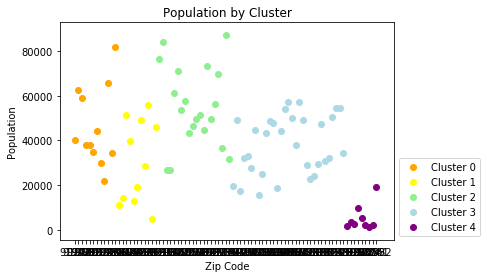

In [84]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
colors = ['Orange', 'Yellow', 'LightGreen', 'LightBlue', 'Purple']
for i in range(0,5):
    x = ZipAllFeature_merged.loc[ZipAllFeature_merged['Cluster Labels']==i]['ZipCode']
    y = ZipAllFeature_merged.loc[ZipAllFeature_merged['Cluster Labels']==i]['Total Population']
    cols = colors[i]
    ax.scatter(x, y, c=cols, label='Cluster %i'%i)
plt.xlabel('Zip Code')
plt.ylabel('Population')
plt.title('Population by Cluster')
plt.legend(loc='upper left', bbox_to_anchor=(1,0.4))


In [85]:
SummaryPlot = Neighborhood_Summarize.T
SummaryPlot['Cluster'] = ['Median of 0','Median of 1','Median of 2',
                         'Median of 3','Median of 4']


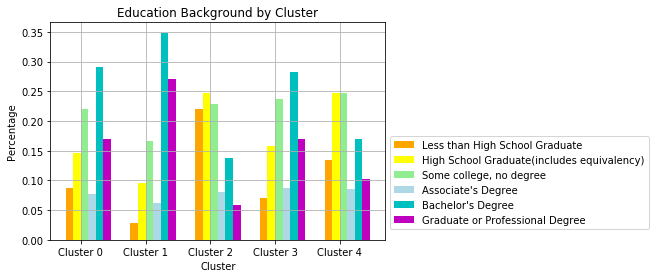

In [86]:
import seaborn as sns

columns = SummaryPlot.columns

ax=plt.gca()
legendlist=[]
y = []
for i in range(28, 34):
    y.append(SummaryPlot.iloc[:,i].values.tolist())
    legendlist.append(columns[i][33:])
ind = np.arange(0, len(SummaryPlot)*3, 3)

w = 0.35
ax.bar(ind-2*w, y[0], width=w, color='orange', align='edge')
ax.bar(ind-w, y[1], width=w, color='Yellow', align='edge')
ax.bar(ind, y[2], width=w, color='LightGreen', align='edge')
ax.bar(ind+w, y[3], width=w, color='LightBlue', align='edge')
ax.bar(ind+2*w, y[4], width=w, color='c', align='edge')
ax.bar(ind+3*w, y[5], width=w, color='m', align='edge')

plt.legend(legendlist,loc='upper left', bbox_to_anchor=(1,0.5))
plt.title('Education Background by Cluster')
plt.xlabel('Cluster')
plt.xticks([0,3,6,9,12],['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'])
plt.ylabel('Percentage')
plt.grid(True)
plt.show()


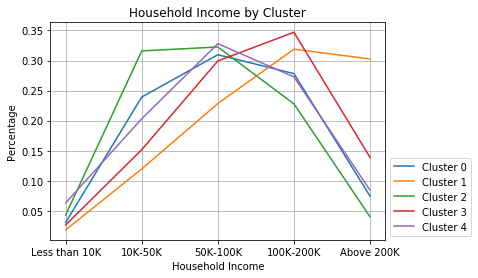

In [87]:
fig, ax = plt.subplots()
ax=plt.gca()
incomeCategory = ['Less than 10K','10K-50K', '50K-100K',
         '100K-200K', 'Above 200K']
clusters = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4']
for i in range(0, 5):
    x=incomeCategory
    y=list(SummaryPlot.iloc[i,12:17])
    plt.plot(incomeCategory, y)
plt.legend(clusters,loc='upper left', bbox_to_anchor=(1,0.4))
plt.title('Household Income by Cluster')
plt.xlabel('Household Income')
plt.ylabel('Percentage')
plt.grid(True)
plt.show()


### Summary of the cluster result

#### Cluster 0
Cluster 0 has those youngest neigborhoods, most population are renting their places with bacholor or lower degree, food and entertainment places are everywhere to accommodate the younger generation.


In [88]:
def listofZipcode(cluster):
    ziplist = ZipAllFeature_merged[ZipAllFeature_merged['Cluster Labels']==cluster]['ZipCode'].values.tolist()
    print('Cluster %d has following zip codes: \n%s'%(cluster,", ".join(ziplist)))
    namelist = ZipAllFeature_merged[ZipAllFeature_merged['Cluster Labels']==cluster]['Name'].unique()
    print('\nNeighborhoods in this cluster:\n%s'%"| ".join(namelist))


In [89]:
listofZipcode(0)

Cluster 0 has following zip codes: 
91942, 91950, 92020, 92083, 92101, 92103, 92104, 92107, 92108, 92115, 92116, 92126

Neighborhoods in this cluster:
LA MESA| NATIONAL CITY| EL CAJON| VISTA| SAN DIEGO, DOWNTOWN| SD, HILLCREST| SD, NORTH PARK| SD, OCEAN BEACH| SD, MISSION VALLEY| SD, COLLEGE GROVE| SD, NORMAL HEIGHTS| SD, MIRA MESA


#### Cluster 1
Cluster 1 has highest income and best education level, families in these neighborhood are likely have annual income above 100K, their kids spread in grades 1 to 12 and undergraduate school.


In [90]:
listofZipcode(1)

Cluster 1 has following zip codes: 
92007, 92014, 92024, 92037, 92075, 92106, 92109, 92110, 92117, 92121, 92127

Neighborhoods in this cluster:
CARDIFF-BY-THE-SEA| DEL MAR| ENCINITAS| LA JOLLA| SOLANA BEACH| SD, POINT LOMA| SD, PACIFIC BEACH| SD, OLD TOWN| SD, CLAIREMONT| SD, SORRENTO VALLEY| SD, RANCHO BERNARDO


#### Cluster 2
 
Cluster 2 has the highest population with a median of 56228 people, more than half families here are renting their houses and have children under 18 years old. People more likely have education degree before college. 

In [95]:
listofZipcode(2)

Cluster 2 has following zip codes: 
91910, 91911, 91932, 91945, 91977, 92021, 92025, 92027, 92054, 92058, 92069, 92084, 92102, 92105, 92111, 92113, 92114, 92139, 92154, 92173

Neighborhoods in this cluster:
CHULA VISTA| IMPERIAL BEACH| LEMON GROVE| SPRING VALLEY| EL CAJON| ESCONDIDO| OCEANSIDE, CAMP PNDLTN| OCEANSIDE| SAN MARCOS| VISTA| SAN DIEGO| SD, CITY HEIGHTS| SD, LINDA VISTA| SD, LOGAN HEIGHTS| SD, ENCANTO| SD, PARADISE HILLS| SD, OTAY MESA| SAN YSIDRO


#### Cluster 3
Cluster 3 is neighborhoods that good for raising a family, most families have kids between grade 1 to 12, probably also have very decent school districts, parents are well educated and able to afford buy their places.

In [92]:
listofZipcode(3)

Cluster 3 has following zip codes: 
91902, 91913, 91914, 91915, 91941, 92008, 92009, 92010, 92011, 92019, 92026, 92028, 92029, 92040, 92056, 92057, 92064, 92065, 92071, 92078, 92081, 92118, 92119, 92120, 92122, 92123, 92124, 92128, 92129, 92130, 92131

Neighborhoods in this cluster:
BONITA| CHULA VISTA| LA MESA| CARLSBAD| EL CAJON| ESCONDIDO| FALLBROOK| LAKESIDE| OCEANSIDE| POWAY| RAMONA| SANTEE| SAN MARCOS| VISTA| CORONADO| SD, NAVAJO| SD, GRANTVILLE| SD, UNIVERSITY| SD, SERRA MESA| SD, TIERRASANTA| SD, RANCHO BERNARDO| SD, RANCHO PENASQUITOS| SD, CARMEL VALLEY| SD, SCRIPPS RANCH


#### Cluster 4

Neighborhoods in cluster 0 are mostly in remote area observed from map, with lowest population compare to other clusters. Majority household income is in 50K to 20K range, age dependency ratio is the highest among all clusters, indicating more elder people are likely living in these neighborhoods.

In [93]:
listofZipcode(4)

Cluster 4 has following zip codes: 
91905, 91906, 91962, 91978, 92003, 92004, 92059, 92061, 92082

Neighborhoods in this cluster:
BOULEVARD| CAMPO| PINE VALLEY| SPRING VALLEY| BONSALL| BORREGO SPGS/OCOTILLO WELLS| PALA| PAUMA VALLEY, PALA| VALLEY CENTER
